<a href="https://colab.research.google.com/github/PondKann/CXR_classification_model/blob/main/DenseNet_Kfold_3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

รายละเอียด 
- 1. Pretrained  รันครบ กรอกแล้ว
- 2. K-fold 0-400  รันครบ กรอกแล้ว
- 3.  K-fold 0-300  แก้ครบแล้ว ไม่ได้รัน

###### import

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
import pickle
import joblib

######Load data // KKUmail

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_dir = '/content/Shared with me/Peoject/Model h5'

In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class/Image'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

######Load data // Gmail

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### train 3 class  
ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 450 ภาพ TB150, Normal151 (เอามาแค่150) และ CA150 (CA คือ lungcancer)

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [ ]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [ ]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [ ]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [ ]:
data_train3 = pd.concat([tnormal[:-1], ttuberculosis, tlungcancer])
data_train3[-3:]

,ImageName,NameType,NumberType
147,ca126.jpg,Lungcancer,2
148,ca142.jpg,Lungcancer,2
149,ca146.jpg,Lungcancer,2


# K-fold Pretrained

### 1  
ไม่ได้รัน binary

#### 1  soft pre bi


In [ ]:
BS = 1                                                      ##
filepath = "Kmodel1_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [04:05<00:00,  1.84it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_)) 

#### 1 soft pre bi adam


In [ ]:
BS = 1                                                            ##
filepath = "Kmodel1_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:15<00:00,  3.32it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 1 soft pre bi sgd

 


In [ ]:
BS = 1                                                      ##
filepath = "Kmodel1_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 82.87it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

#### 1 soft pre cate 


In [ ]:
BS = 1                                                             ##
filepath = "Kmodel1_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=11,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [03:50<00:00,  1.95it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

74850304/74836368 [==============================] - 2s 0us/step
Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 1.0600 - accuracy: 0.4639
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to  Kmodel1_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate1.h5 /assets
360/360 [==============================] - 186s 435ms/step - loss: 1.0600 - accuracy: 0.4639 - val_loss: 0.9883 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.9574 - accuracy: 0.5028
Epoch 2: val_accuracy improved from 0.50000 to 0.64444, saving model to  Kmodel1_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate1.h5 /assets
360/360 [==============================] - 147s 408ms/step - loss: 0.9574 - accuracy: 0.5028 - val_loss: 0.9067 - val_accuracy: 0.6444 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.8923 - accuracy: 0.

#### 1 soft pre cate adam


In [ ]:
BS = 1                                                       ##
filepath = "Kmodel1_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [01:44<00:00,  4.31it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

74850304/74836368 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 1.0940 - accuracy: 0.4000
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to  Kmodel1_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate_adam1.h5 /assets
360/360 [==============================] - 165s 378ms/step - loss: 1.0940 - accuracy: 0.4000 - val_loss: 1.0133 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.9782 - accuracy: 0.5167
Epoch 2: val_accuracy improved from 0.53333 to 0.60000, saving model to  Kmodel1_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate_adam1.h5 /assets
360/360 [==============================] - 96s 268ms/step - loss: 0.9782 - accuracy: 0.5167 - val_loss: 0.9203 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.

#### 1 soft pre cate sgd



In [ ]:
BS = 1                                                       ##
filepath = "Kmodel1_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 95.61it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 1.0904 - accuracy: 0.4361
Epoch 1: val_accuracy improved from -inf to 0.38889, saving model to  Kmodel1_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate_sgd1.h5 /assets
360/360 [==============================] - 116s 282ms/step - loss: 1.0904 - accuracy: 0.4361 - val_loss: 1.0739 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 1.0149 - accuracy: 0.4861
Epoch 2: val_accuracy improved from 0.38889 to 0.53333, saving model to  Kmodel1_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate_sgd1.h5 /assets
360/360 [==============================] - 100s 278ms/step - loss: 1.0149 - accuracy: 0.4861 - val_loss: 1.0002 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.9677 - accuracy: 0.5444
Epoch 3: val_accuracy improved from 0.53333 

### 8 
ไม่ได้รัน binary


#### 8  soft pre bi


In [ ]:
BS = 8                                                      ##
filepath = "Kmodel8_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:08<00:00, 55.08it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filepath = f" model8_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       1.00      0.89      0.94       150
      Normal       0.97      0.95      0.96       150
Tuberculosis       0.86      0.98      0.92       150

    accuracy                           0.94       450
   macro avg       0.95      0.94      0.94       450
weighted avg       0.95      0.94      0.94       450



#### 8 soft pre bi adam  


In [ ]:
BS = 8                                                           ##
filepath = "Kmodel8_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.43it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filepath = f" Kmodel8_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    model = load_model(filepath)

    pred_Dense = model.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 8 soft pre bi sgd  


In [ ]:
BS = 8                                                           ##
filepath = "Kmodel8_soft_pre_bi_sgd.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 84.53it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filepath = f" Kmodel8_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    model = load_model(filepath)

    pred_Dense = model.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 8 soft pre cate     หลังจากนี้ filepath ไม่มี .h5


In [ ]:
BS = 8                                                             ##
filepath = "Kmodel8_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy", baseline=1.0 ,
                patience=15,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

74850304/74836368 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 1.1289 - accuracy: 0.3944
Epoch 1: val_accuracy improved from -inf to 0.48889, saving model to  Kmodel8_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate1.h5 /assets
45/45 [==============================] - 165s 3s/step - loss: 1.1289 - accuracy: 0.3944 - val_loss: 1.0234 - val_accuracy: 0.4889 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 1.0319 - accuracy: 0.4667
Epoch 2: val_accuracy improved from 0.48889 to 0.54444, saving model to  Kmodel8_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate1.h5 /assets
45/45 [==============================] - 125s 3s/step - loss: 1.0319 - accuracy: 0.4667 - val_loss: 0.9911 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.9900 - accuracy: 0.5056
Epoch 3: va

#### 8 soft pre cate adam


In [ ]:
BS = 8                                                       ##
filepath = "Kmodel8_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.93it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 1.1202 - accuracy: 0.3889
Epoch 1: val_accuracy improved from -inf to 0.42222, saving model to  Kmodel8_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_adam1.h5 /assets
45/45 [==============================] - 159s 3s/step - loss: 1.1202 - accuracy: 0.3889 - val_loss: 1.0871 - val_accuracy: 0.4222 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 1.0147 - accuracy: 0.4889
Epoch 2: val_accuracy improved from 0.42222 to 0.48889, saving model to  Kmodel8_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_adam1.h5 /assets
45/45 [==============================] - 128s 3s/step - loss: 1.0147 - accuracy: 0.4889 - val_loss: 1.0513 - val_accuracy: 0.4889 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.9695 - accuracy: 0.5167
Epoch 3: val_accuracy did not improve from 0.48889
45/45

#### 8 soft pre cate sgd


In [ ]:
BS = 8                                                       ##
filepath = "Kmodel8_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.98it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 1.1553 - accuracy: 0.3639
Epoch 1: val_accuracy improved from -inf to 0.36667, saving model to  Kmodel8_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_sgd1.h5 /assets
45/45 [==============================] - 153s 3s/step - loss: 1.1553 - accuracy: 0.3639 - val_loss: 1.1166 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 1.1386 - accuracy: 0.3778
Epoch 2: val_accuracy improved from 0.36667 to 0.37778, saving model to  Kmodel8_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_sgd1.h5 /assets
45/45 [==============================] - 129s 3s/step - loss: 1.1386 - accuracy: 0.3778 - val_loss: 1.1049 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 1.1336 - accuracy: 0.3833
Epoch 3: val_accuracy improved from 0.37778 to 0.38889, savi

### 16  
ไม่ได้รัน binary

#### 16  soft pre bi


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 91.87it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 16 soft pre bi adam 
 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 64.58it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

#### 16 soft pre bi sgd
 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:12<00:00, 35.27it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

#### 16 soft pre cate 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 87.29it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))  

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 1.1519 - accuracy: 0.3227
Epoch 1: val_accuracy improved from -inf to 0.35556, saving model to  Kmodel16_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate1.h5 /assets
22/22 [==============================] - 114s 5s/step - loss: 1.1519 - accuracy: 0.3227 - val_loss: 1.1404 - val_accuracy: 0.3556 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 1.1149 - accuracy: 0.3285
Epoch 2: val_accuracy improved from 0.35556 to 0.41111, saving model to  Kmodel16_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate1.h5 /assets
22/22 [==============================] - 93s 4s/step - loss: 1.1149 - accuracy: 0.3285 - val_loss: 1.1045 - val_accuracy: 0.4111 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 1.0780 - accuracy: 0.4360
Epoch 3: val_accuracy improved from 0.41111 to 0.42222, saving model to  

#### 16 soft pre cate adam


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:30<00:00,  2.99it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

74850304/74836368 [==============================] - 0s 0us/step
Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 1.1321 - accuracy: 0.4070
Epoch 1: val_accuracy improved from -inf to 0.36667, saving model to  Kmodel16_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_adam1.h5 /assets
22/22 [==============================] - 87s 3s/step - loss: 1.1321 - accuracy: 0.4070 - val_loss: 1.0951 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 1.0979 - accuracy: 0.3953
Epoch 2: val_accuracy improved from 0.36667 to 0.38889, saving model to  Kmodel16_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_adam1.h5 /assets
22/22 [==============================] - 60s 3s/step - loss: 1.0979 - accuracy: 0.3953 - val_loss: 1.0684 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 1.0639 - accura

#### 16 soft pre cate sgd

In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 96.76it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 1.1225 - accuracy: 0.4651
Epoch 1: val_accuracy improved from -inf to 0.42222, saving model to  Kmodel16_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_sgd1.h5 /assets
22/22 [==============================] - 78s 3s/step - loss: 1.1225 - accuracy: 0.4651 - val_loss: 1.0965 - val_accuracy: 0.4222 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 1.0515 - accuracy: 0.4971
Epoch 2: val_accuracy improved from 0.42222 to 0.46667, saving model to  Kmodel16_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_sgd1.h5 /assets
22/22 [==============================] - 65s 3s/step - loss: 1.0515 - accuracy: 0.4971 - val_loss: 1.0569 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 1.0150 - accuracy: 0.4971
Epoch 3: val_accuracy improved from 0.46667 to 0.47778, sa

### 32
ไม่ได้รัน binary

#### 32  soft pre bi


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   
3
aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [04:17<00:00,  1.75it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))   

#### 32 soft pre bi adam


In [ ]:
BS = 32                                                      ##
filepath = "Kmodel32_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 83.68it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 32 soft pre bi sgd


In [ ]:
BS = 32                                                      ##
filepath = "Kmodel32_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 85.88it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 32 soft pre cate 


In [ ]:
BS = 32                                                             ##
filepath = "Kmodel32_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:07<00:00, 59.63it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_)) 

Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.2475 - accuracy: 0.3551
Epoch 1: val_accuracy improved from -inf to 0.35556, saving model to  Kmodel32_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate1.h5 /assets
11/11 [==============================] - 173s 15s/step - loss: 1.2475 - accuracy: 0.3551 - val_loss: 1.1155 - val_accuracy: 0.3556 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.1664 - accuracy: 0.3506
Epoch 2: val_accuracy improved from 0.35556 to 0.45556, saving model to  Kmodel32_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate1.h5 /assets
11/11 [==============================] - 138s 14s/step - loss: 1.1664 - accuracy: 0.3506 - val_loss: 1.0783 - val_accuracy: 0.4556 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 1.1122 - accuracy: 0.3659
Epoch 3: val_accuracy did not improve from 0.45556
11/11 [============

#### 32 soft pre cate adam


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 86.78it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.6281 - accuracy: 0.3293
Epoch 1: val_accuracy improved from -inf to 0.32222, saving model to  Kmodel32_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate_adam1.h5 /assets
11/11 [==============================] - 104s 9s/step - loss: 1.6281 - accuracy: 0.3293 - val_loss: 1.2785 - val_accuracy: 0.3222 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.3326 - accuracy: 0.3079
Epoch 2: val_accuracy improved from 0.32222 to 0.33333, saving model to  Kmodel32_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate_adam1.h5 /assets
11/11 [==============================] - 87s 9s/step - loss: 1.3326 - accuracy: 0.3079 - val_loss: 1.1213 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 1.1745 - accuracy: 0.3171
Epoch 3: val_accuracy improved from 0.33333 to 0.3666

#### 32 soft pre cate sgd


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 84.60it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.1621 - accuracy: 0.3018
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to  Kmodel32_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate_sgd1.h5 /assets
11/11 [==============================] - 113s 9s/step - loss: 1.1621 - accuracy: 0.3018 - val_loss: 1.1694 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.1452 - accuracy: 0.3476
Epoch 2: val_accuracy improved from 0.33333 to 0.34444, saving model to  Kmodel32_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate_sgd1.h5 /assets
11/11 [==============================] - 87s 9s/step - loss: 1.1452 - accuracy: 0.3476 - val_loss: 1.1597 - val_accuracy: 0.3444 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 1.1234 - accuracy: 0.3354
Epoch 3: val_accuracy did not improve from 0.34444
11/11 

# K-fold 0-400   รันครบ กรอกแล้ว

### 8 กรอกแล้ว


#### 8  soft pre bi


In [ ]:
BS = 8                                                      ##
filepath = "Kmodel8_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:08<00:00, 55.08it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filepath = f" model8_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.6806
Epoch 1: val_accuracy improved from -inf to 0.48889, saving model to Kmodel8_soft_pre_bi.h5
45/45 [==============================] - 68s 584ms/step - loss: 0.4543 - accuracy: 0.6806 - val_loss: 0.7668 - val_accuracy: 0.4889 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8111
Epoch 2: val_accuracy improved from 0.48889 to 0.60000, saving model to Kmodel8_soft_pre_bi.h5
45/45 [==============================] - 13s 289ms/step - loss: 0.3066 - accuracy: 0.8111 - val_loss: 0.6333 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.8611
Epoch 3: val_accuracy improved from 0.60000 to 0.73333, saving model to Kmodel8_soft_pre_bi.h5
45/45 [==============================] - 13s 290ms/step - loss: 0.2503 - accuracy: 0.8611 - val_loss: 0.5121 - val_accuracy: 0.

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       1.00      0.89      0.94       150
      Normal       0.97      0.95      0.96       150
Tuberculosis       0.86      0.98      0.92       150

    accuracy                           0.94       450
   macro avg       0.95      0.94      0.94       450
weighted avg       0.95      0.94      0.94       450



In [ ]:
H_Dense.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

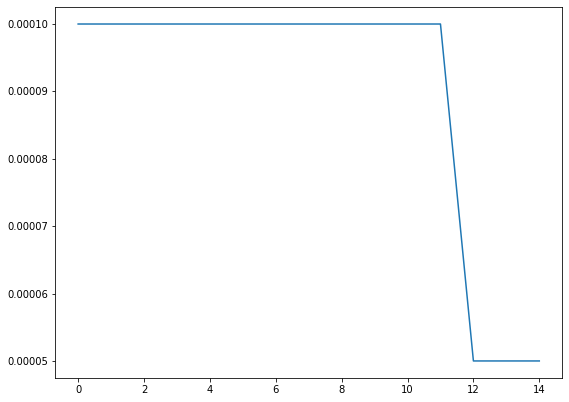

In [ ]:
lr = H_Dense.history['lr']

plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(lr, label = " Learning rate")

#### train-test
0.84

In [ ]:
BS = 8                                                      ##
filepath = "model8_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" , baseline=1.0)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 96.71it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
##
H8_soft_pre_bi = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])


model = load_model('model8_soft_pre_bi.h5')

##
pred_H8_soft_pre_bi = model.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.6687
Epoch 1: val_accuracy improved from -inf to 0.60177, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 58s 537ms/step - loss: 0.4776 - accuracy: 0.6687 - val_loss: 0.4812 - val_accuracy: 0.6018 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.8237
Epoch 2: val_accuracy improved from 0.60177 to 0.66372, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 13s 304ms/step - loss: 0.2910 - accuracy: 0.8237 - val_loss: 0.4901 - val_accuracy: 0.6637 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.8450
Epoch 3: val_accuracy improved from 0.66372 to 0.73451, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 13s 304ms/step - loss: 0.2525 - accuracy: 0.8450 - val_loss: 0.4152 - val_accuracy: 0.7345 - lr: 

In [ ]:
print(H8_soft_pre_bi.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


load model K-fold

In [ ]:
model = load_model('Kmodel8_soft_pre_bi.h5')

In [ ]:
p = model.predict(x_test_Dense)

In [ ]:
print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        p.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       1.00      0.92      0.96        36
      Normal       1.00      0.95      0.97        40
Tuberculosis       0.88      1.00      0.94        37

    accuracy                           0.96       113
   macro avg       0.96      0.96      0.96       113
weighted avg       0.96      0.96      0.96       113



In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

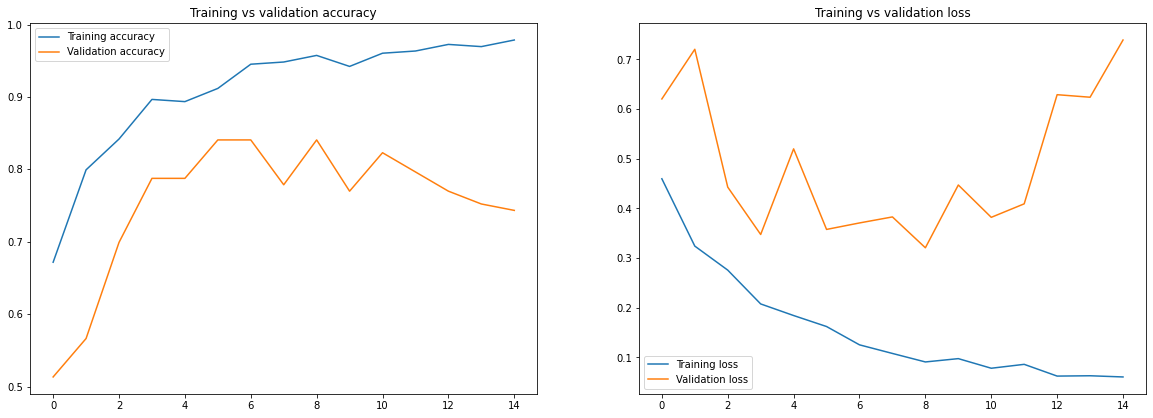

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi                            ##
pred_Dense = pred_H8_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[33  0  3]
 [ 0 38  2]
 [ 0  0 37]]
Normalized confusion matrix
[[0.92 0.   0.08]
 [0.   0.95 0.05]
 [0.   0.   1.  ]]


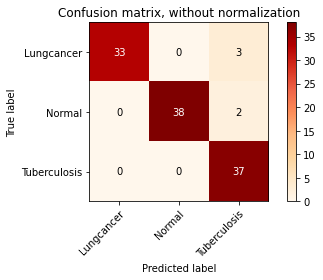

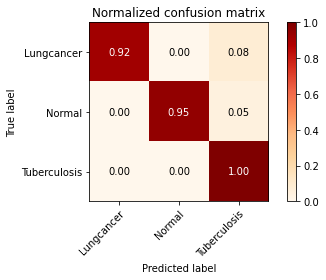

In [ ]:
y_pred = p.argmax(axis=1)            ##ลองแก้ p เป็น model K-fpld
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    # filepath = f" model8_soft_pre_bi{fold}.h5 "
    print(f"Fold #{fold}")

        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


Fold #1
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9944
Epoch 1: val_accuracy improved from -inf to 0.87912, saving model to model8_soft_pre_bi.h5
45/45 [==============================] - 13s 285ms/step - loss: 0.0210 - accuracy: 0.9944 - val_loss: 0.3196 - val_accuracy: 0.8791 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9889
Epoch 2: val_accuracy did not improve from 0.87912
45/45 [==============================] - 11s 238ms/step - loss: 0.0226 - accuracy: 0.9889 - val_loss: 0.2779 - val_accuracy: 0.8791 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9889
Epoch 3: val_accuracy did not improve from 0.87912
45/45 [==============================] - 11s 238ms/step - loss: 0.0210 - accuracy: 0.9889 - val_loss: 3.8633 - val_accuracy: 0.3956 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.

train

In [ ]:
BS = 8                                                      ##
filepath = "Train_model8_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:07<00:00, 57.25it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H8_soft_pre_bi = model_Dense2.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H8_soft_pre_bi = model_Dense2.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.6455
Epoch 1: val_accuracy improved from -inf to 0.66372, saving model to Train_model8_soft_pre_bi.h5
42/42 [==============================] - 53s 532ms/step - loss: 0.4754 - accuracy: 0.6455 - val_loss: 0.4866 - val_accuracy: 0.6637 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8303
Epoch 2: val_accuracy improved from 0.66372 to 0.68142, saving model to Train_model8_soft_pre_bi.h5
42/42 [==============================] - 12s 297ms/step - loss: 0.3111 - accuracy: 0.8303 - val_loss: 0.4675 - val_accuracy: 0.6814 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.8697
Epoch 3: val_accuracy improved from 0.68142 to 0.75221, saving model to Train_model8_soft_pre_bi.h5
42/42 [==============================] - 13s 297ms/step - loss: 0.2318 - accuracy: 0.8697 - val_loss: 0.3740 - val_accur

In [ ]:
tmodel = load_model('/content/Train_model8_soft_pre_bi.h5')

In [ ]:
tpred_H8_soft_pre_bi = tmodel.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        tpred_H8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.96      0.66      0.78        35
      Normal       0.97      0.95      0.96        41
Tuberculosis       0.71      0.95      0.81        37

    accuracy                           0.86       113
   macro avg       0.88      0.85      0.85       113
weighted avg       0.88      0.86      0.86       113



In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

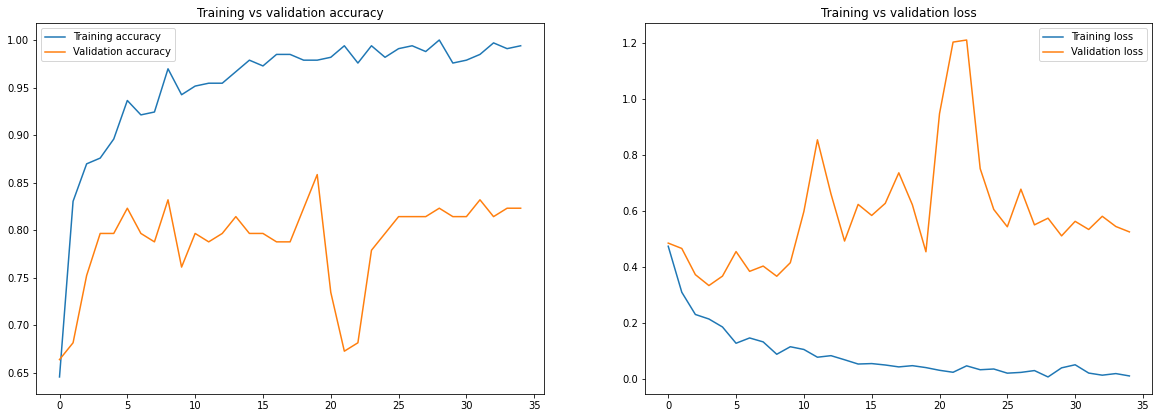

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi                            ##
pred_Dense = pred_H8_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  0 15]
 [ 0 37  4]
 [ 0  1 36]]
Normalized confusion matrix
[[0.57 0.   0.43]
 [0.   0.9  0.1 ]
 [0.   0.03 0.97]]


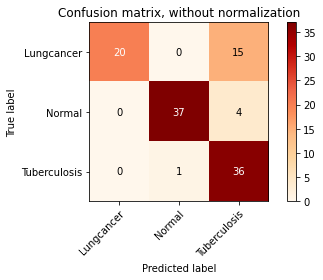

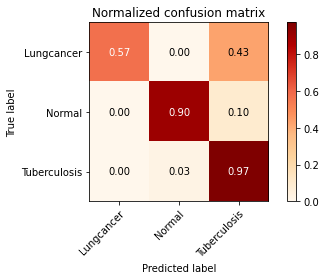

In [ ]:
y_pred = pred_H8_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre bi adam  


In [ ]:
BS = 8                                                           ##
filepath = "Kmodel8_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.43it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filepath = f" Kmodel8_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    model = load_model(filepath)

    pred_Dense = model.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9083
Epoch 1: val_accuracy improved from -inf to 0.72222, saving model to  Kmodel8_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_bi1.h5 /assets
45/45 [==============================] - 144s 3s/step - loss: 0.1866 - accuracy: 0.9083 - val_loss: 0.4820 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9194
Epoch 2: val_accuracy improved from 0.72222 to 0.84444, saving model to  Kmodel8_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_bi1.h5 /assets
45/45 [==============================] - 126s 3s/step - loss: 0.1805 - accuracy: 0.9194 - val_loss: 0.3011 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9583
Epoch 3: val_accuracy did not improve from 0.84444
45/45 [==========================

#### 8 soft pre bi sgd  


In [ ]:
BS = 8                                                           ##
filepath = "Kmodel8_soft_pre_bi_sgd.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 84.53it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filepath = f" Kmodel8_soft_pre_bi{fold}.h5 "
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    model = load_model(filepath)

    pred_Dense = model.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.2833
Epoch 1: val_accuracy improved from -inf to 0.37778, saving model to  Kmodel8_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_bi1.h5 /assets
45/45 [==============================] - 188s 3s/step - loss: 0.7324 - accuracy: 0.2833 - val_loss: 0.7121 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.3389
Epoch 2: val_accuracy did not improve from 0.37778
45/45 [==============================] - 11s 235ms/step - loss: 0.7058 - accuracy: 0.3389 - val_loss: 0.7010 - val_accuracy: 0.3222 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.3472
Epoch 3: val_accuracy did not improve from 0.37778
45/45 [==============================] - 11s 244ms/step - loss: 0.6915 - accuracy: 0.3472 - val_loss: 0.6925 - val_accuracy: 0.3111 - lr: 1.0000e-

#### train-test

In [ ]:
BS = 8                                                           ##
filepath = "model8_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 87.87it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_bi_adam = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

In [ ]:
H_Dense = H8_soft_pre_bi_adam                            ##
pred_Dense = pred_H8_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

In [ ]:
y_pred = pred_H8_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 8 soft pre cate     หลังจากนี้ filepath ไม่มี .h5


In [ ]:
BS = 8                                                             ##
filepath = "Kmodel8_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy", baseline=1.0 ,
                patience=15,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:10<00:00, 41.72it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.6861
Epoch 1: val_accuracy improved from -inf to 0.54444, saving model to  Kmodel8_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate1.h5 /assets
45/45 [==============================] - 239s 4s/step - loss: 0.7064 - accuracy: 0.6861 - val_loss: 1.2710 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8417
Epoch 2: val_accuracy improved from 0.54444 to 0.72222, saving model to  Kmodel8_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate1.h5 /assets
45/45 [==============================] - 168s 4s/step - loss: 0.4290 - accuracy: 0.8417 - val_loss: 0.7888 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.4225 - accuracy: 0.8139
Epoch 3: val_accuracy did not improve from 0.72222
45/45 [==================

#### 8 soft pre cate adam


In [ ]:
BS = 8                                                       ##
filepath = "Kmodel8_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 92.81it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.6639
Epoch 1: val_accuracy improved from -inf to 0.64444, saving model to  Kmodel8_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_adam1.h5 /assets
45/45 [==============================] - 113s 2s/step - loss: 0.7478 - accuracy: 0.6639 - val_loss: 0.8566 - val_accuracy: 0.6444 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8278
Epoch 2: val_accuracy improved from 0.64444 to 0.67778, saving model to  Kmodel8_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_adam1.h5 /assets
45/45 [==============================] - 93s 2s/step - loss: 0.4546 - accuracy: 0.8278 - val_loss: 0.8032 - val_accuracy: 0.6778 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8722
Epoch 3: val_accuracy improved from 0.67778 to 0.76667, s

#### 8 soft pre cate sgd


In [ ]:
BS = 8                                                       ##
filepath = "Kmodel8_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 87.37it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 1.2036 - accuracy: 0.3278
Epoch 1: val_accuracy improved from -inf to 0.34444, saving model to  Kmodel8_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_sgd1.h5 /assets
45/45 [==============================] - 111s 2s/step - loss: 1.2036 - accuracy: 0.3278 - val_loss: 1.2799 - val_accuracy: 0.3444 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.3750
Epoch 2: val_accuracy improved from 0.34444 to 0.35556, saving model to  Kmodel8_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel8_soft_pre_cate_sgd1.h5 /assets
45/45 [==============================] - 91s 2s/step - loss: 1.1213 - accuracy: 0.3750 - val_loss: 1.1766 - val_accuracy: 0.3556 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 1.0840 - accuracy: 0.3750
Epoch 3: val_accuracy improved from 0.35556 to 0.38889, savin

### 16  กรอกแล้ว


#### 16  soft pre bi


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 91.87it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.6847
Epoch 1: val_accuracy improved from -inf to 0.54444, saving model to  Kmodel16_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_bi1.h5 /assets
22/22 [==============================] - 125s 4s/step - loss: 0.4551 - accuracy: 0.6847 - val_loss: 0.5360 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.8430
Epoch 2: val_accuracy did not improve from 0.54444
22/22 [==============================] - 9s 386ms/step - loss: 0.2927 - accuracy: 0.8430 - val_loss: 0.6120 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.8953
Epoch 3: val_accuracy improved from 0.54444 to 0.56667, saving model to  Kmodel16_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_bi1.h5 /assets
22/22 [=====================

#### 16 soft pre bi adam 
 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 64.58it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.6541
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to  Kmodel16_soft_pre_bi_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_bi_adam1.h5 /assets
22/22 [==============================] - 116s 5s/step - loss: 0.4911 - accuracy: 0.6541 - val_loss: 0.4994 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8314
Epoch 2: val_accuracy improved from 0.60000 to 0.63333, saving model to  Kmodel16_soft_pre_bi_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_bi_adam1.h5 /assets
22/22 [==============================] - 91s 4s/step - loss: 0.2842 - accuracy: 0.8314 - val_loss: 0.4703 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.8750
Epoch 3: val_accuracy improved from 0.63333 to 0.70000, savin

#### 16 soft pre bi sgd
 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:12<00:00, 35.27it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.3953
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to  Kmodel16_soft_pre_bi_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_bi_sgd1.h5 /assets
22/22 [==============================] - 128s 5s/step - loss: 0.6529 - accuracy: 0.3953 - val_loss: 0.7128 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.4157
Epoch 2: val_accuracy improved from 0.30000 to 0.35556, saving model to  Kmodel16_soft_pre_bi_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_bi_sgd1.h5 /assets
22/22 [==============================] - 85s 4s/step - loss: 0.6494 - accuracy: 0.4157 - val_loss: 0.7026 - val_accuracy: 0.3556 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.3983
Epoch 3: val_accuracy did not improve from 0.35556
22/22 [=======

#### 16 soft pre cate 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 97.07it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))  

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.6977
Epoch 1: val_accuracy improved from -inf to 0.51111, saving model to  Kmodel16_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate1.h5 /assets
22/22 [==============================] - 118s 4s/step - loss: 0.6862 - accuracy: 0.6977 - val_loss: 0.9336 - val_accuracy: 0.5111 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8430
Epoch 2: val_accuracy improved from 0.51111 to 0.56667, saving model to  Kmodel16_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate1.h5 /assets
22/22 [==============================] - 89s 4s/step - loss: 0.3895 - accuracy: 0.8430 - val_loss: 1.0079 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8837
Epoch 3: val_accuracy improved from 0.56667 to 0.62222, saving model to  

#### 16 soft pre cate adam


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 94.54it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.6570
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to  Kmodel16_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_adam1.h5 /assets
22/22 [==============================] - 111s 4s/step - loss: 0.7359 - accuracy: 0.6570 - val_loss: 1.0159 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8488
Epoch 2: val_accuracy did not improve from 0.55556
22/22 [==============================] - 8s 365ms/step - loss: 0.3907 - accuracy: 0.8488 - val_loss: 1.2088 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9099
Epoch 3: val_accuracy improved from 0.55556 to 0.65556, saving model to  Kmodel16_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_adam1.h5 /assets


#### 16 soft pre cate sgd

In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 84.65it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 1.2646 - accuracy: 0.3169
Epoch 1: val_accuracy improved from -inf to 0.31111, saving model to  Kmodel16_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_sgd1.h5 /assets
22/22 [==============================] - 103s 4s/step - loss: 1.2646 - accuracy: 0.3169 - val_loss: 1.2756 - val_accuracy: 0.3111 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 1.2097 - accuracy: 0.3517
Epoch 2: val_accuracy improved from 0.31111 to 0.32222, saving model to  Kmodel16_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel16_soft_pre_cate_sgd1.h5 /assets
22/22 [==============================] - 85s 4s/step - loss: 1.2097 - accuracy: 0.3517 - val_loss: 1.2357 - val_accuracy: 0.3222 - lr: 1.0000e-04
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 1.1653 - accuracy: 0.3808
Epoch 3: val_accuracy improved from 0.32222 to 0.33333, s

### 32 กรอกแล้ว

#### 32  soft pre bi


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   
3
aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [04:17<00:00,  1.75it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))   

74850304/74836368 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.6311
Epoch 1: val_accuracy improved from -inf to 0.63333, saving model to  Kmodel32_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_bi1.h5 /assets
11/11 [==============================] - 135s 10s/step - loss: 0.5366 - accuracy: 0.6311 - val_loss: 0.5836 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8293
Epoch 2: val_accuracy did not improve from 0.63333
11/11 [==============================] - 8s 658ms/step - loss: 0.3306 - accuracy: 0.8293 - val_loss: 0.6259 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9116
Epoch 3: val_accuracy did not improve from 0.63333
11/11 [==============================] - 8s 660ms/step - loss: 0.2304 - accurac

#### 32 soft pre bi adam


In [ ]:
BS = 32                                                      ##
filepath = "Kmodel32_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 83.68it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.6555
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to  Kmodel32_soft_pre_bi_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_bi_adam1.h5 /assets
11/11 [==============================] - 108s 9s/step - loss: 0.5054 - accuracy: 0.6555 - val_loss: 0.5326 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.7988
Epoch 2: val_accuracy improved from 0.53333 to 0.60000, saving model to  Kmodel32_soft_pre_bi_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_bi_adam1.h5 /assets
11/11 [==============================] - 87s 9s/step - loss: 0.3353 - accuracy: 0.7988 - val_loss: 0.4975 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.8811
Epoch 3: val_accuracy did not improve from 0.60000
11/11 [===

#### 32 soft pre bi sgd


In [ ]:
BS = 32                                                      ##
filepath = "Kmodel32_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 85.88it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.8401 - accuracy: 0.3110
Epoch 1: val_accuracy improved from -inf to 0.26667, saving model to  Kmodel32_soft_pre_bi_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_bi_sgd1.h5 /assets
11/11 [==============================] - 104s 9s/step - loss: 0.8401 - accuracy: 0.3110 - val_loss: 0.7475 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.8209 - accuracy: 0.2835
Epoch 2: val_accuracy improved from 0.26667 to 0.27778, saving model to  Kmodel32_soft_pre_bi_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_bi_sgd1.h5 /assets
11/11 [==============================] - 84s 8s/step - loss: 0.8209 - accuracy: 0.2835 - val_loss: 0.7423 - val_accuracy: 0.2778 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.8078 - accuracy: 0.3171
Epoch 3: val_accuracy did not improve from 0.27778
11/11 [=======

#### 32 soft pre cate 


In [ ]:
BS = 32                                                             ##
filepath = "Kmodel32_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 83.35it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_)) 

Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.8403 - accuracy: 0.6433
Epoch 1: val_accuracy improved from -inf to 0.54444, saving model to  Kmodel32_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate1.h5 /assets
11/11 [==============================] - 113s 9s/step - loss: 0.8403 - accuracy: 0.6433 - val_loss: 1.5558 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.8354
Epoch 2: val_accuracy did not improve from 0.54444
11/11 [==============================] - 8s 657ms/step - loss: 0.4207 - accuracy: 0.8354 - val_loss: 1.5400 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9299
Epoch 3: val_accuracy did not improve from 0.54444
11/11 [==============================] - 7s 653ms/step - loss: 0.2581 - accuracy: 0.9299 - val_loss: 1.8473 - val_accuracy: 0.5222 - lr: 1.00

#### 32 soft pre cate adam


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 86.18it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.8667 - accuracy: 0.5945
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to  Kmodel32_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate_adam1.h5 /assets
11/11 [==============================] - 108s 9s/step - loss: 0.8667 - accuracy: 0.5945 - val_loss: 1.2753 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8079
Epoch 2: val_accuracy improved from 0.40000 to 0.45556, saving model to  Kmodel32_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate_adam1.h5 /assets
11/11 [==============================] - 90s 9s/step - loss: 0.4623 - accuracy: 0.8079 - val_loss: 1.3086 - val_accuracy: 0.4556 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.8994
Epoch 3: val_accuracy improved from 0.45556 to 0.5444

#### 32 soft pre cate sgd


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:12<00:00,  3.40it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

74850304/74836368 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.4536 - accuracy: 0.3232
Epoch 1: val_accuracy improved from -inf to 0.31111, saving model to  Kmodel32_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate_sgd1.h5 /assets
11/11 [==============================] - 122s 9s/step - loss: 1.4536 - accuracy: 0.3232 - val_loss: 1.2423 - val_accuracy: 0.3111 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.3627 - accuracy: 0.3445
Epoch 2: val_accuracy improved from 0.31111 to 0.32222, saving model to  Kmodel32_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel32_soft_pre_cate_sgd1.h5 /assets
11/11 [==============================] - 85s 8s/step - loss: 1.3627 - accuracy: 0.3445 - val_loss: 1.1915 - val_accuracy: 0.3222 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 1.3147 - accuracy:

### 1  กรอกแล้ว

#### 1  soft pre bi


In [ ]:
BS = 1                                                      ##
filepath = "Kmodel1_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [04:05<00:00,  1.84it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_)) 

74850304/74836368 [==============================] - 2s 0us/step
Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.5028
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to  Kmodel1_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi1.h5 /assets
360/360 [==============================] - 165s 361ms/step - loss: 0.5945 - accuracy: 0.5028 - val_loss: 0.5657 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.6444
Epoch 2: val_accuracy improved from 0.56667 to 0.63333, saving model to  Kmodel1_soft_pre_bi1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi1.h5 /assets
360/360 [==============================] - 119s 331ms/step - loss: 0.4509 - accuracy: 0.6444 - val_loss: 0.4303 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.7083
Epo

#### 1 soft pre bi adam


In [ ]:
BS = 1                                                            ##
filepath = "Kmodel1_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:15<00:00,  3.32it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

74850304/74836368 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 0.5943 - accuracy: 0.4944
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to  Kmodel1_soft_pre_bi_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi_adam1.h5 /assets
360/360 [==============================] - 173s 396ms/step - loss: 0.5943 - accuracy: 0.4944 - val_loss: 0.5499 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.6750
Epoch 2: val_accuracy improved from 0.56667 to 0.63333, saving model to  Kmodel1_soft_pre_bi_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi_adam1.h5 /assets
360/360 [==============================] - 129s 360ms/step - loss: 0.4539 - accuracy: 0.6750 - val_loss: 0.5254 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.3993 - 

#### 1 soft pre bi sgd

 


In [ ]:
BS = 1                                                      ##
filepath = "Kmodel1_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 82.87it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.3111
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to  Kmodel1_soft_pre_bi_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_bi_sgd1.h5 /assets
360/360 [==============================] - 142s 342ms/step - loss: 0.6913 - accuracy: 0.3111 - val_loss: 0.6854 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.3028
Epoch 2: val_accuracy did not improve from 0.30000
360/360 [==============================] - 39s 107ms/step - loss: 0.6420 - accuracy: 0.3028 - val_loss: 0.6703 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.3000
Epoch 3: val_accuracy did not improve from 0.30000
360/360 [==============================] - 39s 107ms/step - loss: 0.6378 - accuracy: 0.3000 - val_loss: 0.6710 - val_accuracy

#### 1 soft pre cate 


In [ ]:
BS = 1                                                             ##
filepath = "Kmodel1_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=11,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:08<00:00, 51.86it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 1.0254 - accuracy: 0.4583
Epoch 1: val_accuracy improved from -inf to 0.51111, saving model to  Kmodel1_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate1.h5 /assets
360/360 [==============================] - 181s 388ms/step - loss: 1.0254 - accuracy: 0.4583 - val_loss: 1.1781 - val_accuracy: 0.5111 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0.6500
Epoch 2: val_accuracy improved from 0.51111 to 0.62222, saving model to  Kmodel1_soft_pre_cate1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate1.h5 /assets
360/360 [==============================] - 138s 385ms/step - loss: 0.7566 - accuracy: 0.6500 - val_loss: 0.8863 - val_accuracy: 0.6222 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.7000
Epoch 3: val_accuracy did not improve from 0.62222
360/360 [

#### 1 soft pre cate adam


In [ ]:
BS = 1                                                       ##
filepath = "Kmodel1_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:11<00:00,  3.41it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

74850304/74836368 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 0.9918 - accuracy: 0.5167
Epoch 1: val_accuracy improved from -inf to 0.43333, saving model to  Kmodel1_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate_adam1.h5 /assets
360/360 [==============================] - 159s 362ms/step - loss: 0.9918 - accuracy: 0.5167 - val_loss: 1.1485 - val_accuracy: 0.4333 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.6861
Epoch 2: val_accuracy improved from 0.43333 to 0.53333, saving model to  Kmodel1_soft_pre_cate_adam1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate_adam1.h5 /assets
360/360 [==============================] - 120s 334ms/step - loss: 0.7071 - accuracy: 0.6861 - val_loss: 1.5867 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 0

#### 1 soft pre cate sgd



In [ ]:
BS = 1                                                       ##
filepath = "Kmodel1_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:26<00:00,  3.06it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

74850304/74836368 [==============================] - 1s 0us/step
Fold #1
Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 1.1177 - accuracy: 0.3167
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to  Kmodel1_soft_pre_cate_sgd1.h5 
INFO:tensorflow:Assets written to:  Kmodel1_soft_pre_cate_sgd1.h5 /assets
360/360 [==============================] - 152s 346ms/step - loss: 1.1177 - accuracy: 0.3167 - val_loss: 1.2196 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 1.1074 - accuracy: 0.2833
Epoch 2: val_accuracy did not improve from 0.30000
360/360 [==============================] - 37s 103ms/step - loss: 1.1074 - accuracy: 0.2833 - val_loss: 1.2127 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 1.0991 - accuracy: 0.3611
Epoch 3: val_accuracy did not improve from 0.30000
360/360 [==============================] - 37s 103ms/ste

# K-fold 0-300
แก้ 300 ครบแล้ว  ไม่ได้รันเพิ่ม

### 8 


#### 8  soft pre bi


In [ ]:
BS = 8                                                      ##
filepath = "Kmodel8_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:08<00:00, 55.08it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" {filepath}{fold}.h5 "
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       1.00      0.89      0.94       150
      Normal       0.97      0.95      0.96       150
Tuberculosis       0.86      0.98      0.92       150

    accuracy                           0.94       450
   macro avg       0.95      0.94      0.94       450
weighted avg       0.95      0.94      0.94       450



In [ ]:
H_Dense.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
lr = H_Dense.history['lr']

plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(lr, label = " Learning rate")

#### 8 soft pre bi adam  


In [ ]:
BS = 8                                                           ##
filepath = "Kmodel8_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 66.43it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    model = load_model(filepath)

    pred_Dense = model.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 8 soft pre bi sgd  


In [ ]:
BS = 8                                                           ##
filepath = "Kmodel8_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 84.53it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")

    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    model = load_model(filepath)

    pred_Dense = model.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 8 soft pre cate  


In [ ]:
BS = 8                                                             ##
filepath = "Kmodel8_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy", baseline=1.0 ,
                patience=15,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:10<00:00, 41.72it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 8 soft pre cate adam


In [ ]:
BS = 8                                                       ##
filepath = "Kmodel8_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 92.81it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 8 soft pre cate sgd


In [ ]:
BS = 8                                                       ##
filepath = "Kmodel8_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 87.37it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

### 16  


#### 16  soft pre bi


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 91.87it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 16 soft pre bi adam 
 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
#                     save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:06<00:00, 64.58it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

#### 16 soft pre bi sgd
 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:12<00:00, 35.27it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

#### 16 soft pre cate 


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 97.07it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))  

#### 16 soft pre cate adam


In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:04<00:00, 94.54it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 16 soft pre cate sgd

In [ ]:
BS = 16                                                       ##
filepath = "Kmodel16_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 84.65it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

### 32

#### 32  soft pre bi


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   
3
aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [04:17<00:00,  1.75it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))   

#### 32 soft pre bi adam


In [ ]:
BS = 32                                                      ##
filepath = "Kmodel32_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 83.68it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 32 soft pre bi sgd


In [ ]:
BS = 32                                                      ##
filepath = "Kmodel32_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 85.88it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 32 soft pre cate 


In [ ]:
BS = 32                                                             ##
filepath = "Kmodel32_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 83.35it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_)) 

#### 32 soft pre cate adam


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 86.18it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 32 soft pre cate sgd


In [ ]:
BS = 32                                                       ##
filepath = "Kmodel32_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:12<00:00,  3.40it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

### 1  

#### 1  soft pre bi


In [ ]:
BS = 1                                                      ##
filepath = "Kmodel1_soft_pre_bi"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [04:05<00:00,  1.84it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_)) 

#### 1 soft pre bi adam


In [ ]:
BS = 1                                                            ##
filepath = "Kmodel1_soft_pre_bi_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:15<00:00,  3.32it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 1 soft pre bi sgd

 


In [ ]:
BS = 1                                                      ##
filepath = "Kmodel1_soft_pre_bi_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:05<00:00, 82.87it/s] 


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

#### 1 soft pre cate 


In [ ]:
BS = 1                                                             ##
filepath = "Kmodel1_soft_pre_cate"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=11,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [00:08<00:00, 51.86it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))    

#### 1 soft pre cate adam


In [ ]:
BS = 1                                                       ##
filepath = "Kmodel1_soft_pre_cate_adam"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:11<00:00,  3.41it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 1 soft pre cate sgd



In [ ]:
BS = 1                                                       ##
filepath = "Kmodel1_soft_pre_cate_sgd"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=13,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 450/450 [02:26<00:00,  3.06it/s]


In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:300]:    #fix w & bias in layer 0-300
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### K-fold
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1   
    print(f"Fold #{fold}")
    filename = f" {filepath}{fold}.h5 "
    # print(filename)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

    # model = load_model(filename)

    pred_Dense = model_Dense.predict(x_test_Dense)

    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))